In [24]:
import numpy as np

In [25]:
events_file = "Datasety/NCaltech/Caltech101/crab/image_0023.bin"
f = open(events_file, 'rb')
raw_data = np.fromfile(f, dtype=np.uint8)
f.close()

# Extract x, y, t and p from raw data.
# From https://github.com/uzh-rpg/aegnn/blob/master/aegnn/datasets/ncaltech101.py

raw_data = np.uint32(raw_data)
all_y = raw_data[1::5]
all_x = raw_data[0::5]
all_p = (raw_data[2::5] & 128) >> 7  # bit 7
all_ts = ((raw_data[2::5] & 127) << 16) | (raw_data[3::5] << 8) | (raw_data[4::5])
all_ts = all_ts  
all_p = all_p.astype(np.float64)
all_p[all_p == 0] = -1

events = {}
events['x'] = all_x
events['y'] = all_y
events['t'] = all_ts
events['p'] = all_p

In [26]:
print(np.max(events['x']))
print(np.max(events['y']))

232
140


In [27]:
print(events)

{'x': array([ 31,  62, 100, ...,  79, 140, 204], dtype=uint32), 'y': array([ 14,  38,   1, ...,  77,  77, 136], dtype=uint32), 't': array([    45,     60,    103, ..., 300328, 300333, 300333], dtype=uint32), 'p': array([ 1.,  1., -1., ..., -1.,  1., -1.])}


In [28]:
print(all_ts)

[    45     60    103 ... 300328 300333 300333]


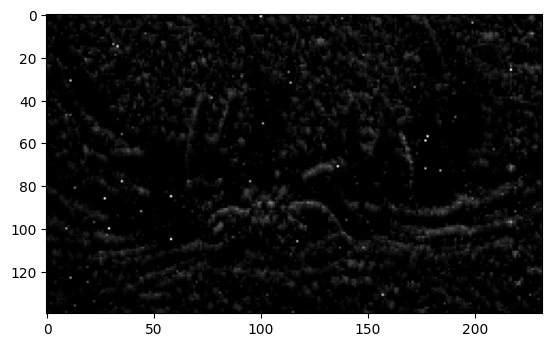

1.0


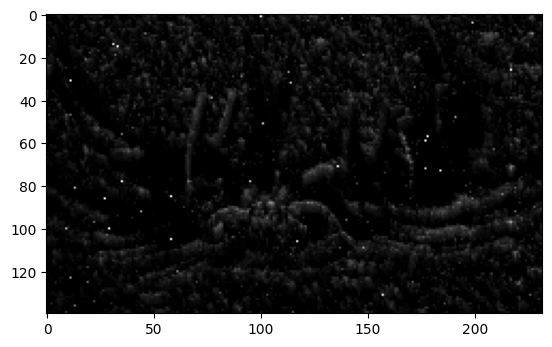

1.0


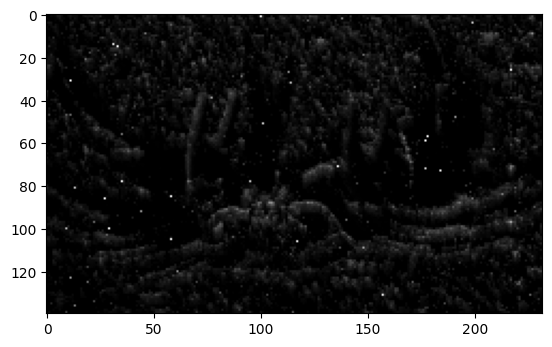

1.0


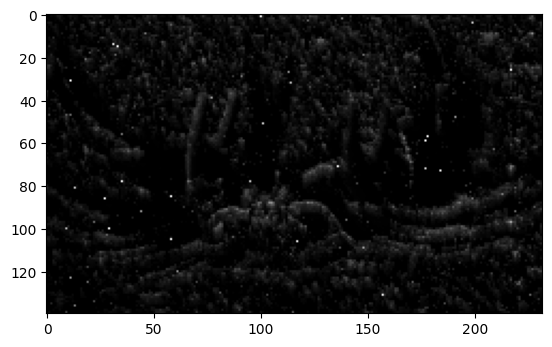

1.0


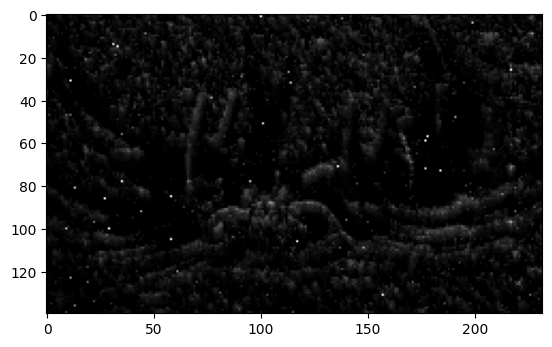

1.0


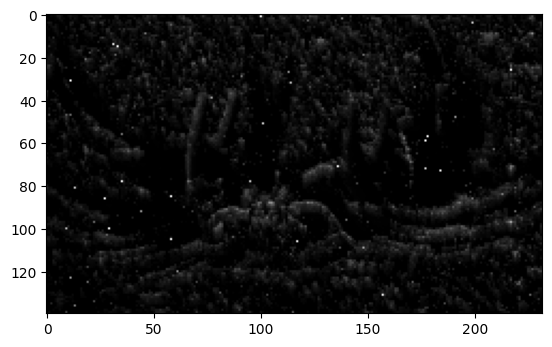

1.0


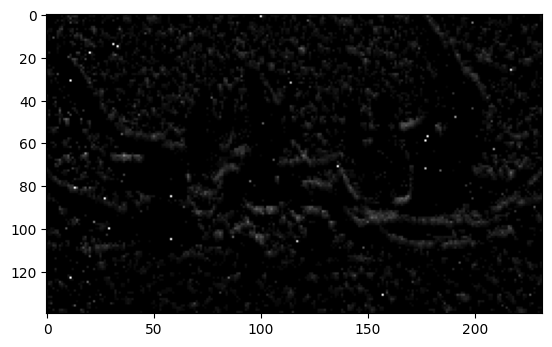

1.0


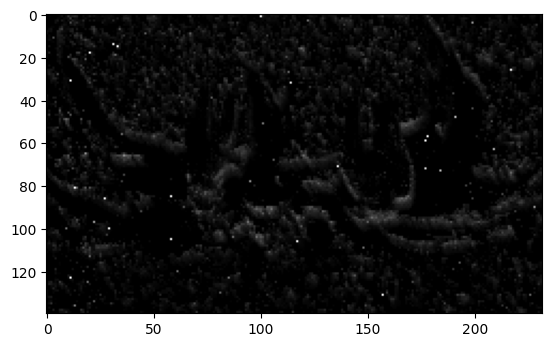

1.0


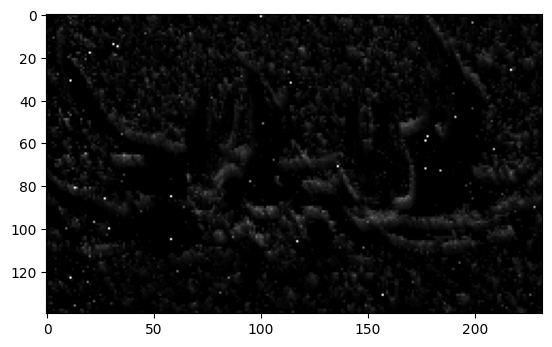

1.0


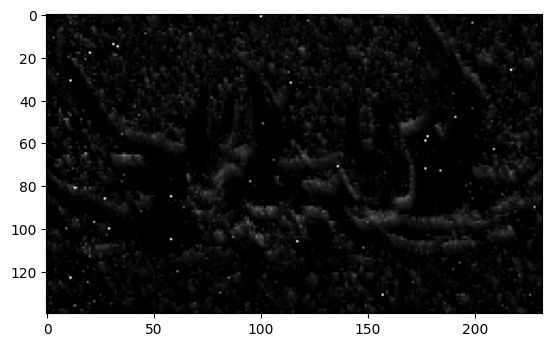

1.0


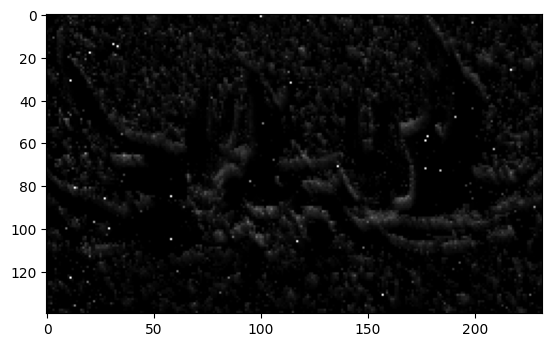

1.0


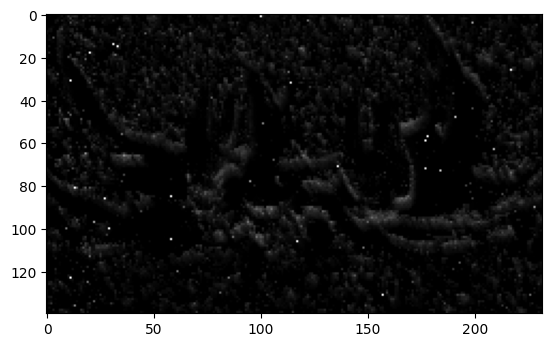

1.0
232 140


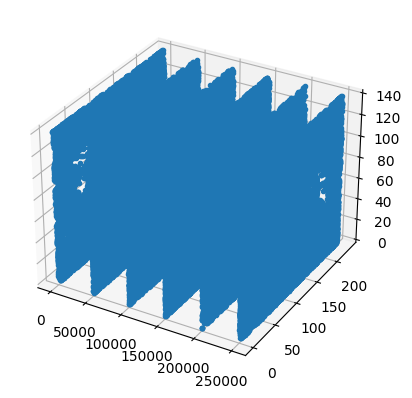

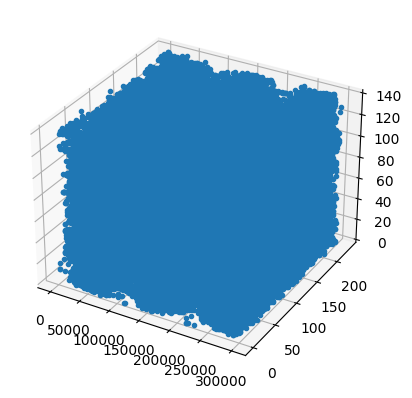

In [29]:
import matplotlib.pyplot as plt
import scipy

# do something with the events
noBins = 6
tau = 0.6
alpha = 0.1
pic = np.zeros((2*noBins,np.max(events['y'])+1,np.max(events['x'])+1))
pic3D = []
pic3D_quantized = []
temp_x = 0   
temp_y = 0
delta_t = (float(all_ts[-1])+0.00001)/noBins
# print(delta_t)
for event in range(len(all_ts)):
    t,x,y,p = events['t'][event], events['x'][event], events['y'][event], events['p'][event]
    # print(t,x,y,p)
    temp_x = max(temp_x, x)
    temp_y = max(temp_y, y)
    for i in range(int(np.floor(float(t)/delta_t)), noBins):
        pic[int(i+(max(p,0)*noBins)),y,x] = min(pic[int(i+(max(p,0)*noBins)),y,x] + alpha*np.exp((i-t)/((delta_t)*tau))/tau, 1)
    # pic[int(np.floor(float(t)/delta_t)),y,x] = max(pic[int(np.floor(float(t)/delta_t)),y,x], 1)
    
    pic3D_quantized.append([int(np.floor(float(t)/delta_t)) * delta_t,x,y])
    pic3D.append([t,x,y])

pic = np.array(pic)
for i in range(2*noBins):
    pic2 = pic[i,:temp_y,:temp_x]
    plt.gray()
    plt.imshow(pic2)
    plt.show()
    print(np.max(pic2))



ax = plt.figure().add_subplot(projection='3d')
pic3D_quantized = np.array(pic3D_quantized)
ax.plot(pic3D_quantized[:,0], pic3D_quantized[:,1], pic3D_quantized[:,2], '.')


ax = plt.figure().add_subplot(projection='3d')
pic3D = np.array(pic3D)
ax.plot(pic3D[:,0], pic3D[:,1], pic3D[:,2], '.')
print(temp_x, temp_y)

In [30]:
import os
import cv2
import matplotlib.pyplot as plt
import scipy
import argparse
import pickle as pkl
from Dataset import Dataset
from model import *
import time
from copy import deepcopy

from tqdm import tqdm

In [31]:


noBins = 3
tau = 0.8
alpha = 0.1
name_dirs = [
"accordion",
"airplanes",
"anchor",
"ant",
"BACKGROUND_Google",
"barrel",
"bass",
"beaver",
"binocular",
"bonsai",
"brain",
"brontosaurus",
"buddha",
"butterfly",
"camera",
"cannon",
"car_side",
"ceiling_fan",
"cellphone",
"chair",
"chandelier",
"cougar_body",
"cougar_face",
"crab",
"crayfish",
"crocodile",
"crocodile_head",
"cup",
"dalmatian",
"dollar_bill",
"dolphin",
"dragonfly",
"electric_guitar",
"elephant",
"emu",
"euphonium",
"ewer",
"Faces_easy",
"ferry",
"flamingo",
"flamingo_head",
"garfield",
"gerenuk",
"gramophone",
"grand_piano",
"hawksbill",
"headphone",
"hedgehog",
"helicopter",
"ibis",
"inline_skate",
"joshua_tree",
"kangaroo",
"ketch",
"lamp",
"laptop",
"Leopards",
"llama",
"lobster",
"lotus",
"mandolin",
"mayfly",
"menorah",
"metronome",
"minaret",
"Motorbikes",
"nautilus",
"octopus",
"okapi",
"pagoda",
"panda",
"pigeon",
"pizza",
"platypus",
"pyramid",
"revolver",
"rhino",
"rooster",
"saxophone",
"schooner",
"scissors",
"scorpion",
"sea_horse",
"snoopy",
"soccer_ball",
"stapler",
"starfish",
"stegosaurus",
"stop_sign",
"strawberry",
"sunflower",
"tick",
"trilobite",
"umbrella",
"watch",
"water_lilly",
"wheelchair",
"wild_cat",
"windsor_chair",
"wrench",
"yin_yang"]

dataset_x = []
dataset_y = []

train_dir = "C:/D/time_to_spike/in_torch/Datasety/NCaltech/Caltech101/"
for num, label_name in enumerate(name_dirs):
    for filename, _ in zip(os.listdir(train_dir+label_name),tqdm(range(len(os.listdir(train_dir+label_name))))):
        f = open(train_dir+label_name+'/'+filename, 'rb')
        raw_data = np.fromfile(f, dtype=np.uint8)
        f.close()
        raw_data = np.uint32(raw_data)
        all_y = raw_data[1::5]
        all_x = raw_data[0::5]
        all_p = (raw_data[2::5] & 128) >> 7  # bit 7
        all_ts = ((raw_data[2::5] & 127) << 16) | (raw_data[3::5] << 8) | (raw_data[4::5])
        all_ts = all_ts  
        all_p = all_p.astype(np.float64)
        all_p[all_p == 0] = -1

        events = {}
        events['x'] = all_x
        events['y'] = all_y
        events['t'] = all_ts
        events['p'] = all_p

        max_x = np.max(events['x'])+1
        max_y = np.max(events['y'])+1
        delta_t = (float(all_ts[-1])+0.00001)/noBins
        pic = np.zeros((noBins*2,max_y,max_x),dtype= np.float32)
        for event in range(len(all_ts)):
            t,x,y,p = events['t'][event], events['x'][event], events['y'][event], events['p'][event]
            for i in range(int(np.floor(float(t)/delta_t)), noBins):
                pic[int(i+(max(p,0)*noBins)),y,x] = min(pic[int(i+(max(p,0)*noBins)),y,x] + alpha*np.exp((i-t)/((delta_t)*tau))/tau, 1)
            #pic[y,x] += t*(p-0.5)*2 #*t
        # pic = gausianBlur3D(pic)
        # normalized_image = cv2.normalize(pic, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        normalized_image = np.transpose(pic, (1,2, 0))
        dataset_x.append(np.transpose(cv2.resize(normalized_image, (224, 224)),(2,0,1)))
        dataset_y.append(num)

dataset_x = np.array(dataset_x)
dataset_y = np.array(dataset_y)

 98%|█████████▊| 59/60 [00:53<00:00,  1.10it/s]


In [32]:
print(name_dirs.__len__())

101


In [33]:
dir_dataset = "Datasety/"
np.save(dir_dataset + 'Ncaltech101_x.npy', dataset_x)
np.save(dir_dataset + 'Ncaltech101_y.npy', dataset_y)